In [ ]:
from IPython.display import display, HTML
display(HTML("<h1 style='color:Purple;'>Logistic Regression (SHAP)</h1>"))

# **ABALONE AGE PREDICTION**

Wadiqa Baig

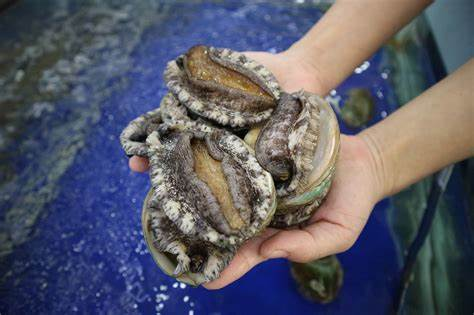

# 1. DATA COLLECTION

## 1.1 Import Required Libraries


In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score,
                                     learning_curve)

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc,
                             roc_auc_score)

# Imbalanced-learn for pipeline
from imblearn.pipeline import Pipeline

# SHAP for model interpretability
!pip install shap
import shap
shap.initjs()


## 1.2 Load Dataset

In [ ]:
# Load the Abalone dataset from UCI Machine Learning Repository
# This dataset contains physical measurements of abalones and their age (rings)
df = pd.read_csv('https://archive.ics.uci.edu/static/public/1/data.csv')

# Display first few rows to understand the data structure
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
# Check dataset dimensions (rows, columns)
print(df.shape)

(4177, 9)


In [ ]:
# Display data types and non-null counts for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# 2. EXPLORATORY DATA ANALYSIS

## Plot 1: Relationship between Whole Weight and Rings (Age)

Text(0.5, 0, 'Whole weight')

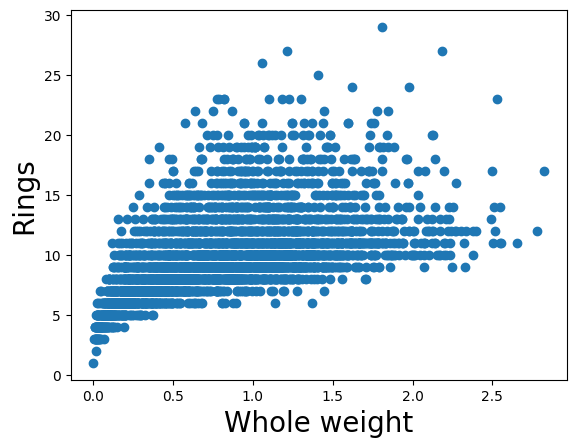

In [ ]:
plt.scatter(df  ['Whole_weight'], df['Rings'])
plt.ylabel('Rings', size=20)
plt.xlabel('Whole weight', size=20)

**Observation:**

There is a clear positive correlation between whole weight and the number of rings, which aligns with the expectation that older abalones tend to be larger and heavier.

---



## Plot 2: Age Distribution by Sex

Text(0.5, 0, 'Sex')

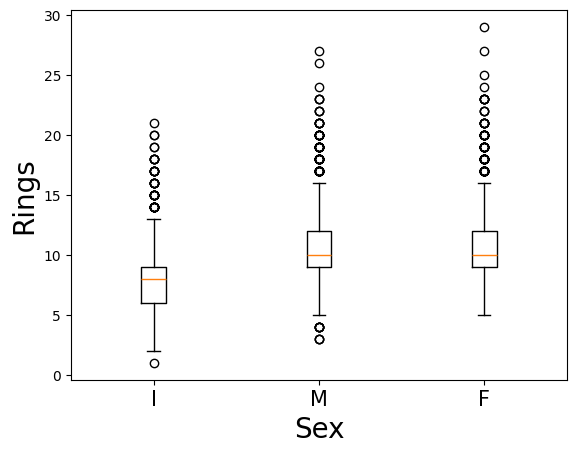

In [ ]:
# Create box plots for each sex category
plt.boxplot(df[df['Sex']=='I']['Rings'], positions=[1])
plt.boxplot(df[df['Sex']=='M']['Rings'], positions=[2])
plt.boxplot(df[df['Sex']=='F']['Rings'], positions=[3])

plt.xticks([1, 2, 3], labels=['I', 'M', 'F'],size= 15)
plt.ylabel('Rings', size=20)
plt.xlabel('Sex', size=20)

**Observation:**

Infants (I) generally have a lower number of rings, indicating a younger age. In contrast, there is minimal difference in the number of rings between Males (M) and Females (F), suggesting similar age distributions across these two groups.

---



## Plot 3: Feature Correlation Analysis

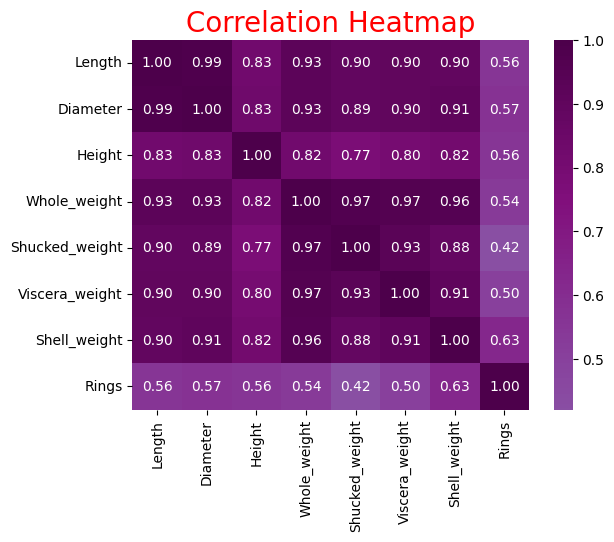

In [ ]:
# Select continuous variables for correlation analysis
cont = ["Length", "Diameter", "Height",
       "Whole_weight", "Shucked_weight",
       "Viscera_weight", "Shell_weight", "Rings"]

# Calculate correlation matrix
corr_matrix = pd.DataFrame(df[cont],columns=cont).corr()

# Create correlation heatmap
sns.heatmap(corr_matrix,
            annot=True,        # Show correlation values
            center=0,          # Center colormap at 0
            cmap='BuPu',       # Purple color scheme
            fmt='.2f')         # Format to 2 decimal places

plt.title('Correlation Heatmap', color="red", size=20)
plt.show()

**Observation:**

Length and diameter are perfectly correlated, indicating a strong linear relationship between these two size measurements. Additionally, whole weight shows a high correlation with other weight-related features such as shucked weight, viscera weight, and shell weight, suggesting that as the abalone’s total mass increases, its component weights increase proportionally.

---



# 3. DATA PREPROCESSING

##3.1 Handle Multicollinearity

Since length and diameter are perfectly correlated, one of them (e.g., length) can be **dropped to avoid redundancy**.

Similarly, due to the high correlation between whole weight and other weight-related features (shucked weight, viscera weight, shell weight), we can consider dropping **whole weight** to reduce multicollinearity.

In [ ]:
# Remove highly correlated features to reduce redundancy
# - Length (perfectly correlated with Diameter)
# - Whole_weight (highly correlated with other weight features)

df = df.drop(['Length', 'Whole_weight'], axis=1)

# Show remaining features
print("Remaining features after dropping:")
print(df.columns.tolist())

Remaining features after dropping:
['Sex', 'Diameter', 'Height', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']


## 3.2 Missing Value Analysis

Check for null values

In [ ]:
print("Null values per column:")
df.isnull().sum()


Null values per column:


,0
Sex,0
Diameter,0
Height,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


Check for zero values (potential data quality issues)

In [ ]:
print("\nZero values per column:")
((df) == 0).sum()


Zero values per column:


,0
Sex,0
Diameter,0
Height,2
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


**Note**: Height contains 2 zero values, which are likely data entry errors
since physical height should be positive.


---



In [ ]:
# Examine records with zero height
df[df['Height']==0]

,Sex,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.34,0.0,0.2065,0.0860,0.1150,8
3996,I,0.23,0.0,0.0575,0.0285,0.3505,6



---

The two zero values in the Height column were replaced with the **mean height** of the remaining (non-zero) entries to handle potential data entry errors and maintain data consistency.

## 3.3 Handle Zero Values in Height

In [ ]:
# Calculate mean height by sex category for imputation
means = pd.pivot_table(df, index=['Sex'], aggfunc={'Height' :np.mean})
means

<ipython-input-143-19286ec419de>:2: FutureWarning: The provided callable <function mean at 0x7b019c99e340> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  means = pd.pivot_table(df, index=['Sex'], aggfunc={'Height' :np.mean})


,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


In [ ]:
# Replace zero heights with overall mean (more conservative approach)
df['Height'] = df['Height'].replace(to_replace=0, value=0.107996)

Verify zero values are handled

In [ ]:
((df) == 0).sum()

,0
Sex,0
Diameter,0
Height,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


## 3.4 Encode Categorical Variables

In [ ]:
# Convert Sex categories to dummy variables (one-hot encoding)
df = pd.get_dummies(df, dtype=int)
df

,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.365,0.095,0.2245,0.1010,0.1500,15,0,0,1
1,0.265,0.090,0.0995,0.0485,0.0700,7,0,0,1
2,0.420,0.135,0.2565,0.1415,0.2100,9,1,0,0
3,0.365,0.125,0.2155,0.1140,0.1550,10,0,0,1
4,0.255,0.080,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...
4172,0.450,0.165,0.3700,0.2390,0.2490,11,1,0,0
4173,0.440,0.135,0.4390,0.2145,0.2605,10,0,0,1
4174,0.475,0.205,0.5255,0.2875,0.3080,9,0,0,1
4175,0.485,0.150,0.5310,0.2610,0.2960,10,1,0,0


## 3.5 Create Binary Target Variable

In [ ]:
# Add an “Age_Group” column: Old= 1, Young= 0

# Define a function to label each abalone
def label_age_group(rings):
    if rings < 9:
        return 0  # Young
    else:
        return 1  # Old

# Apply classification to create binary target
df['Age_Group'] = df['Rings'].apply(label_age_group)

# Check class distribution
count_young = df['Age_Group'].value_counts()[0]
count_old = df['Age_Group'].value_counts()[1]

print(f"Number of young abalones: {count_young}")
print(f"Number of   old abalones: {count_old}")

df.head()

Number of young abalones: 1407
Number of   old abalones: 2770


,Diameter,Height,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M,Age_Group
0,0.365,0.095,0.2245,0.1010,0.150,15,0,0,1,1
1,0.265,0.090,0.0995,0.0485,0.070,7,0,0,1,0
2,0.420,0.135,0.2565,0.1415,0.210,9,1,0,0,1
3,0.365,0.125,0.2155,0.1140,0.155,10,0,0,1,1
4,0.255,0.080,0.0895,0.0395,0.055,7,0,1,0,0


## 3.6 Prepare Features and Target

Assign X → the features (independent variables used to predict)

Assign y → the target (dependent variable to be predicted)

In [ ]:
# Separate features (X) and target (y)
X = df.drop(columns=['Rings', 'Age_Group']) # Drop Age, Rings, and the target variable Age_Group from features
y = df['Age_Group']

In [ ]:
print("Features:", list(X.columns))
print("Target:", y.name)

Features: ['Diameter', 'Height', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Sex_F', 'Sex_I', 'Sex_M']
Target: Age_Group


# 4. DATA SPLITTING

In [ ]:
# Split 80% train, 20% temp (to later split into test and validation)

# First split: 80% train, 20% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,           # 20% for temp (val + test)
    random_state=42
)

# Split 10% test, 10% validation from the temp (which is 20% of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,           # 50% of 20% = 10% each
    random_state=42
)


# 5. CROSS-VALIDATION SETUP

In [ ]:
# Configure stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=10,      # 10-fold CV
                     shuffle=True,      # Shuffle data before splitting
                     random_state=42)   # Reproducible results

# 6. MODEL PIPELINE CONSTRUCTION

In [ ]:
#Create preprocessing and modeling pipeline
pipe = Pipeline([
    # Step 1: Feature scaling (standardization)
    ('scaler', StandardScaler()),
    # Step 2: Logistic regression with initial parameters
    ('logreg', LogisticRegression(C=0.25,
                                  max_iter=1000,
                                  solver= 'lbfgs',
                                  random_state=42))
])

# 7. HYPERPARAMETER OPTIMISATION

In [ ]:
# Define hyperparameter search space
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100],
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['liblinear', 'saga'],  # These support L1
    'logreg__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # For elasticnet only
}

# Perform grid search with cross-validation
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1)

# Fit grid search on training data
grid.fit(X_train, y_train)

# Extract best model
best_model = grid.best_estimator_

# Corrected the variable name in the print statement
print("Best Parameters:", grid.best_params_)

Best Parameters: {'logreg__C': 0.1, 'logreg__l1_ratio': 0.1, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
500 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt

# 8. MODEL EVALUATION

## 8.1 Validation Set Performance

In [ ]:
val_preds = grid.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:\n", classification_report(y_val, val_preds))

Validation Accuracy: 0.8110047846889952
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       140
           1       0.85      0.87      0.86       278

    accuracy                           0.81       418
   macro avg       0.79      0.78      0.79       418
weighted avg       0.81      0.81      0.81       418



## 8.2 Test Set Performance (Final Evaluation)

In [ ]:
test_preds = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:\n", classification_report(y_test, test_preds))

Test Accuracy: 0.8588516746411483
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.77       139
           1       0.87      0.92      0.90       279

    accuracy                           0.86       418
   macro avg       0.85      0.83      0.84       418
weighted avg       0.86      0.86      0.86       418



# 9. CONFUSION MATRIX ANALYSIS

Correct Predictions: 359/418
Accuracy: 85.89%
Error: 14.11%


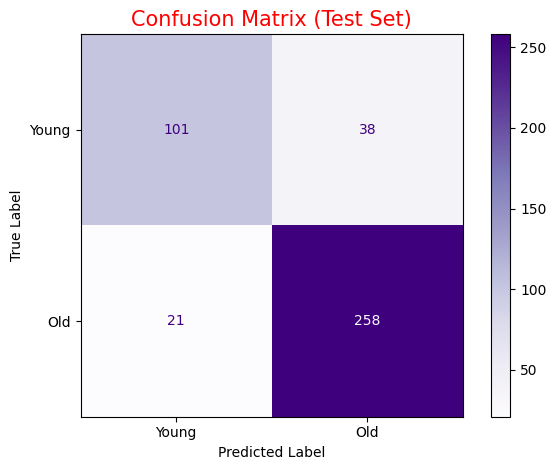

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Correct predictions (sum of the diagonal)
correct_predictions = np.trace(cm)

# Total predictions
total_predictions = np.sum(cm)

# Incorrect predictions
incorrect_predictions = total_predictions - correct_predictions

# Accuracy and error
accuracy_percentage = (correct_predictions / total_predictions) * 100
error_percentage = (incorrect_predictions / total_predictions) * 100

# Display
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Error: {error_percentage:.2f}%")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Young", "Old"])
disp.plot(cmap="Purples", values_format='d')

plt.title("Confusion Matrix (Test Set)",  color= "red", size=15)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

# 10. ROC CURVE AND AUC ANALYSIS

AUC Score: 0.9240607513988809


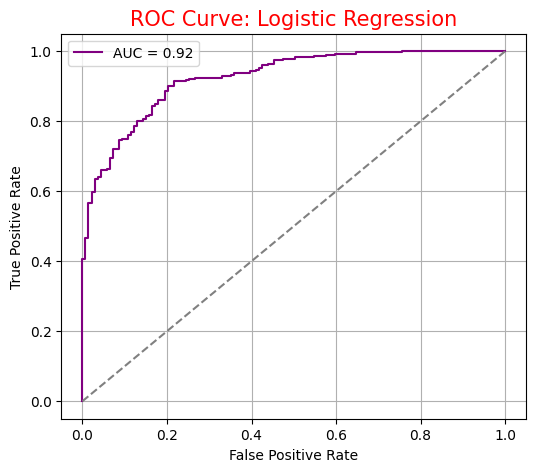

In [ ]:
# Use the best model found by GridSearchCV
y_pred_prob = grid.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression', color= "red", size=15)
plt.grid(True)
plt.legend()
plt.show()


# 11. VALIDATION VS TEST ACCURACY COMPARISON

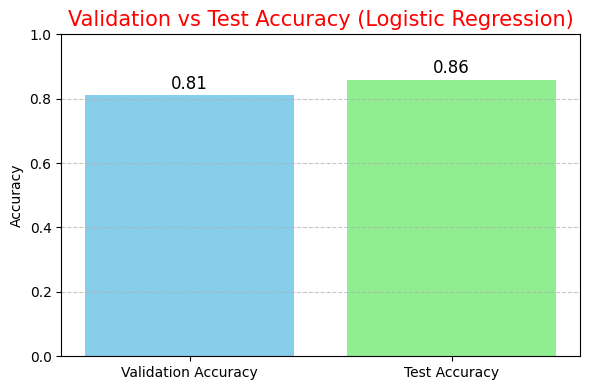

In [ ]:
# Predictions
val_preds = best_model.predict(X_val)
test_preds = best_model.predict(X_test)

# Accuracies
val_accuracy = accuracy_score(y_val, val_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Validation Accuracy', 'Test Accuracy'], [val_accuracy, test_accuracy], color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Validation vs Test Accuracy (Logistic Regression)', color= "red", size=15)
for i, acc in enumerate([val_accuracy, test_accuracy]):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 12. LEARNING CURVE ANALYSIS

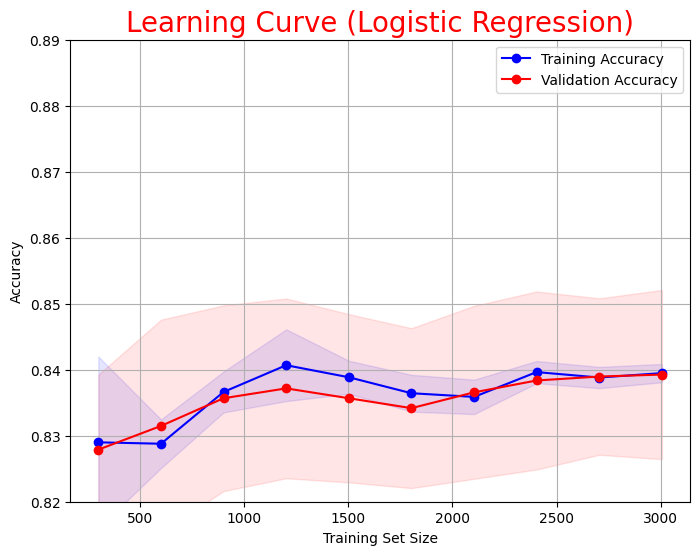

Train scores:
 [[0.79       0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
  0.83333333 0.83333333 0.83333333 0.83333333]
 [0.83693844 0.83527454 0.82695507 0.82695507 0.82695507 0.82695507
  0.82695507 0.82695507 0.82695507 0.82695507]
 [0.84128746 0.84239734 0.84017758 0.83462819 0.83462819 0.83462819
  0.83462819 0.83462819 0.83462819 0.83462819]
 [0.83610649 0.84193012 0.8327787  0.82945092 0.84442596 0.84442596
  0.84442596 0.84442596 0.84442596 0.84442596]
 [0.83699268 0.8409847  0.833666   0.83499667 0.84031936 0.84031936
  0.84031936 0.84031936 0.84031936 0.84031936]
 [0.83416528 0.8363838  0.82972823 0.83416528 0.83749307 0.8380477
  0.83860233 0.83860233 0.83860233 0.83860233]
 [0.83269962 0.83507605 0.83079848 0.8365019  0.83412548 0.83697719
  0.83602662 0.83887833 0.83887833 0.83887833]
 [0.83777038 0.84109817 0.83693844 0.83985025 0.83860233 0.83777038
  0.8406822  0.84234609 0.8406822  0.8406822 ]
 [0.83807763 0.84177449 0.83622921 0.83807763 0.83696858 0.8391866

In [ ]:
# Use the best estimator from GridSearchCV for the learning curve
best_model = grid.best_estimator_


# Generate learning curve data using the same model and parameters
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train,
                                                        cv=10,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.ylim(0.82, 0.89)  # Set y-axis range from 60% to 100%

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation Accuracy')

# Plot shaded regions for standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)

plt.title('Learning Curve (Logistic Regression)', size=20, color="red")
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("Train scores:\n", train_scores)
print("Train mean:\n", train_mean)


# 13. MODEL EXPLAINABILITY (SHAP ANALYSIS)

In [ ]:
# Extract the scaler and model
scaler = best_model.named_steps['scaler']
logreg = best_model.named_steps['logreg']

In [ ]:
# Transform test set
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SHAP with original feature names
explainer = shap.Explainer(logreg, X_test_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

## 13.1 Feature Importance Bar Plot

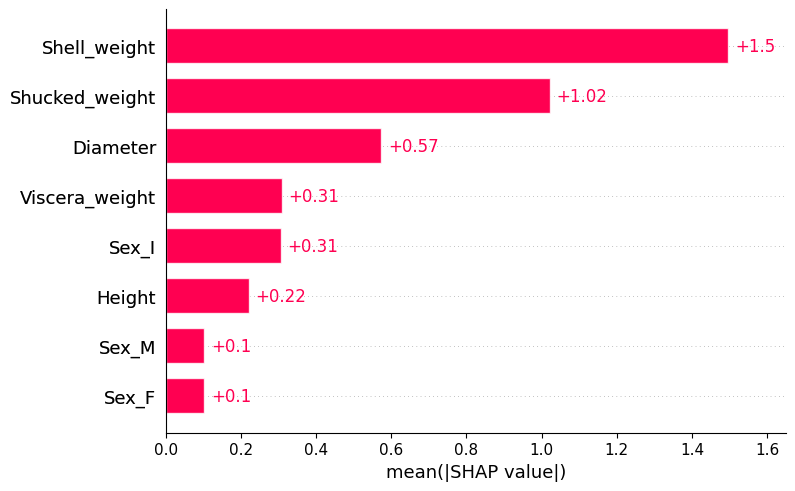

In [ ]:
# Summary bar plot (with original feature names)
display(HTML("<h1 style='color:red;'>SHAP Summary Bar Plot: Global Feature Importance</h1>"))
shap.plots.bar(shap_values)

## 13.2 Waterfall Plot (Single Prediction Explanation)

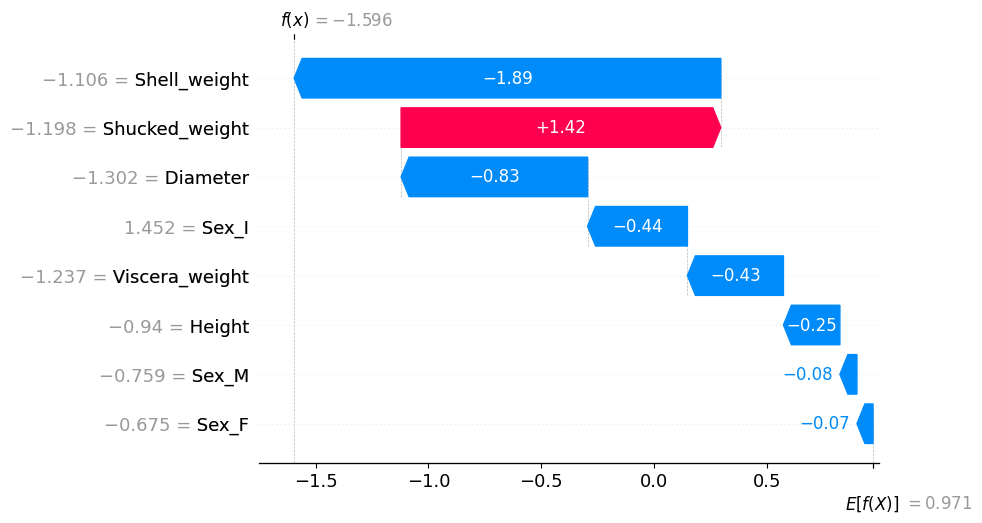

In [ ]:
# Waterfall plot
display(HTML("<h1 style='color:red;'> SHAP Waterfall Plot for Test Instance 0</h3>"))
shap.plots.waterfall(shap_values[0])


## 13.3 Force Plot

In [ ]:
import shap
shap.initjs()

display(HTML("<h1 style='color:red;'>SHAP Force Plot for Test Instance 0</h1>"))

# Force plot
shap.force_plot(explainer.expected_value, shap_values[0].values, feature_names=X.columns, matplotlib=False)

#**By: Wadiqa, Hiba, Fatima and Pooja**